In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#from torch.optim.lr_scheduler import _LRScheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from torchsummary import summary
import random

# GPU 사용이 가능할 경우, GPU를 사용할 수 있게 함.'
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

#print(os.environ.get('CUDA_VISIBLE_DEVICES'))

cuda


In [2]:
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        return x.view_as(x)
    @staticmethod
    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return grad_output * (-1)

class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(224*224*64, 10)
        self.fc2 = nn.Linear(10, 3) # source = 0, target = 1 회귀 가정

    def forward(self, x):
        x = x.view(-1, 224*224*64)
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        
        return torch.sigmoid(x)

class IdentityBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(IdentityBlock, self).__init__()
        
        # 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Adding the skip connection
        out += self.skip(identity)
        out = self.relu2(out)
        
        return out


#인코더 블럭
class Conv2(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv2,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        p = self.maxpool(x)
        
        return x , p
class Conv3(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv3,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        p = self.maxpool(x)
        
        return x , p
class Conv4(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv4,self).__init__()         
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        p = self.maxpool(x)
        
        return x , p
class Conv5(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Conv5,self).__init__() 
        self.identityblock1 = IdentityBlock(in_channels,in_channels)
        self.identityblock2 = IdentityBlock(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
        
    def forward(self,x):
        x = self.identityblock1(x)
        x = self.identityblock2(x)
        p = self.maxpool(x)
        
        return x , p
#디코더 블럭
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super(DecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(channels*2, channels, kernel_size=4, stride=2, padding=1) # output_padding 추가
        self.convblock1 = IdentityBlock(channels*2, channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)))
        x = torch.cat([x, skip], dim=1)
        x = self.convblock1(x)
        #print("x",x.shape,"skip: ",skip.shape)
        return x



#Unet구조 middle의 xm값의 움직임에 주의
class Resnet18_Unet(nn.Module):
    def __init__(self,n_classes):
        super(Resnet18_Unet,self).__init__()
        self.fconv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.fbn1 = nn.BatchNorm2d(64)
        self.frelu1 = nn.ReLU()
        self.fmaxpooling = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.conv2 = Conv2(64,128)
        self.conv3 = Conv3(128,256)
        self.conv4 = Conv4(256,512)
        self.conv5 = Conv5(512,1024)
        
        self.middleconv = IdentityBlock(1024,2048)
        self.dropout = nn.Dropout2d(0.1) #
           
        self.decoder5 = DecoderBlock(1024)
        self.decoder4 = DecoderBlock(512)
        self.decoder3 = DecoderBlock(256)
        self.decoder2 = DecoderBlock(128)
        self.decoder1 = DecoderBlock(64)
        self.transpose = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1) # output_padding 추가
        
        self.segmap = nn.Conv2d(64,n_classes, kernel_size=1)
        #self.domain_classifier = domain_classifier()
        
    def forward(self,x):
        x = self.fconv1(x)#3->64
        x0 = self.fbn1(x)
        x1 = self.frelu1(x)
        p = self.fmaxpooling(x1)#첫 conv: x0([8, 64, 109, 109]) p([8, 64, 54, 54])
        #print("conv1: ",x1.shape, "maxpooling: ",p.shape)
        x2,p = self.conv2(p)
        #print("conv2: ",x2.shape, "maxpooling: ",p.shape)
        x3,p = self.conv3(p)
        #print("conv3: ",x3.shape, "maxpooling: ",p.shape)
        x4,p = self.conv4(p)
        #print("conv4: ",x4.shape, "maxpooling: ",p.shape)
        x5,p = self.conv5(p)
        #print("conv5: ",x5.shape, "maxpooling: ",p.shape)
        
        xm = self.middleconv(p)#xm([8, 4096, 2, 2])
        #print("xm: ",xm.shape, "maxpooling: ",p.shape)
        xm = self.dropout(xm)
        
        x = self.decoder5(xm,x5)#뉴런:2048*2->2048 1
        x = self.decoder4(x,x4)#뉴런:1024*2->1024 
        x = self.decoder3(x,x3) #14
        x = self.decoder2(x,x2)#28
        x = self.decoder1(x,x1)#55
        x = self.transpose(x)
        
        #print(x.shape)
        #x = F.interpolate(x, size=(224, 224))
        x_c = self.segmap(x)
        #x_d = self.domain_classifier(x)
        
        return x_c

In [3]:
def apply_fisheye_distortion(images, masks=None, label=1):
    # 이미지 크기 가져오기
    batch, channel, height, width = images.shape

    # 카메라 매트릭스 생성
    focal_length = width / 4
    center_x = width / 2
    center_y = height / 2
    camera_matrix = np.array([[focal_length, 0, center_x],
                              [0, focal_length, center_y],
                              [0, 0, 1]], dtype=np.float32)

    # 왜곡 계수 생성
    label = random.randint(0, label)
    dist_coeffs = np.array([0, 0.2 * label, 0, 0], dtype=np.float32)

    # 왜곡 보정
    undistorted_images = []
    undistorted_masks = []

    for i in range(batch):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
        undistorted_image = torch.from_numpy(undistorted_image).permute(2, 0, 1).float().to(device)
        undistorted_images.append(undistorted_image)
        
        if masks is not None:
            mask = masks[i].cpu().numpy()
            undistorted_mask = cv2.undistort(mask, camera_matrix, dist_coeffs)
            undistorted_mask = np.round(undistorted_mask).astype(np.uint8)
            undistorted_mask[undistorted_mask > 12] = 12
            undistorted_mask = torch.from_numpy(undistorted_mask).long().to(device)
            undistorted_masks.append(undistorted_mask)

    undistorted_images = torch.stack(undistorted_images, dim=0)
    if masks is not None:
        undistorted_masks = torch.stack(undistorted_masks, dim=0)
    else:
        undistorted_masks = None

    return undistorted_images, undistorted_masks


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, apply_distortion=False, label=1):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.apply_distortion = apply_distortion
        self.label = label
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #directory_path = "/mnt/nas27/Dataset/Samsung_DM"
        directory_path = './dataset'
        img_path = self.data.iloc[idx, 1]
        img_path = directory_path + img_path
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.transpose(image, (2, 0, 1))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if self.apply_distortion:
            image, _ = apply_fisheye_distortion(torch.tensor(image).unsqueeze(0), None, self.label)
            image = image.squeeze(0).cpu().numpy()
            
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        return image

transform = A.Compose([
    #A.Normalize(),
    ToTensorV2(),
])


In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import torch
# 원본 데이터 로드
dataset_original = CustomDataset('./dataset/train_source.csv', transform=transform)
dataloader_original = DataLoader(dataset_original, batch_size=100, shuffle=True)

dataset_distorted = CustomDataset('./dataset/train_source.csv', transform=transform, apply_distortion=True,label=3)
dataloader_distorted = DataLoader(dataset_distorted, batch_size=100, shuffle=True)
#모델 불러오기
model = Resnet18_Unet(n_classes=13).to(device)
model.load_state_dict(torch.load('./dataset/resnet18_unet_fixed.pth'), strict=False)
model.eval()

original_data = iter(dataloader_original)
distorted_data = iter(dataloader_distorted)

original = next(original_data)
distorted = next(distorted_data)
features = []
def hook_fn(module, input, output):
    features.append(output)
    
layer_to_get = model.decoder1
hook = layer_to_get.register_forward_hook(hook_fn)

# 데이터 로드
original_data_iter = iter(dataloader_original)
distorted_data_iter = iter(dataloader_distorted)
original = next(original_data_iter).float().to(device)
distorted = next(distorted_data_iter).float().to(device)

# 모델을 통과
with torch.no_grad():
    model(original)
    original_features = torch.cat(features).cpu().numpy()
    features.clear()
    
    model(distorted)
    distorted_features = torch.cat(features).cpu().numpy()



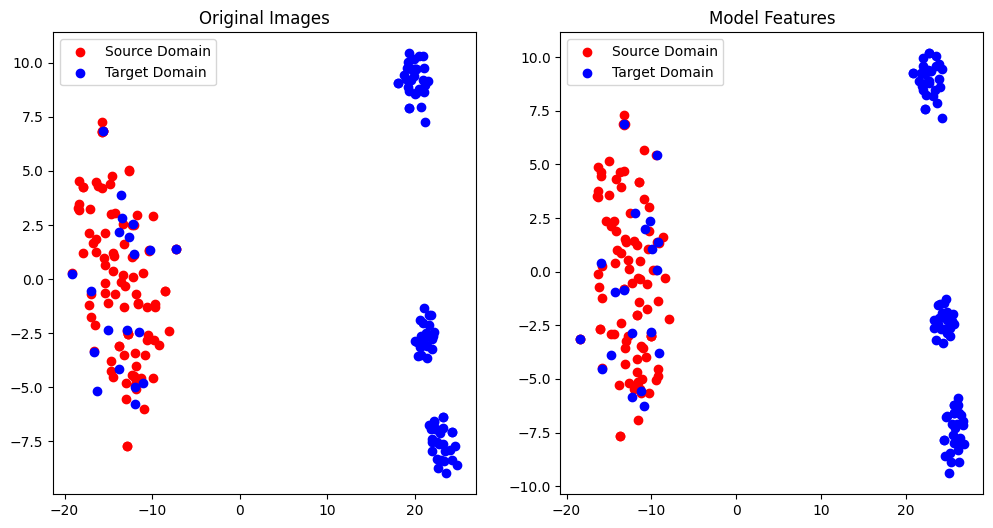

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# 3. t-SNE 변환
tsne = TSNE(n_components=2)
df = pd.DataFrame(np.concatenate([original_features.reshape(original_features.shape[0], -1), distorted_features.reshape(distorted_features.shape[0], -1)], 0))
image_tsne = tsne.fit_transform(df)
df = pd.DataFrame(np.concatenate([original_features.reshape(original_features.shape[0], -1), distorted_features.reshape(distorted_features.shape[0], -1)], 0))
features_tsne = tsne.fit_transform(df)
# 4. 시각화
plt.figure(figsize=(12, 6))

# 왼쪽: 원본 이미지의 t-SNE 결과
plt.subplot(1, 2, 1)
i0 = image_tsne[:100]
i1 = image_tsne[100:]
plt.scatter(i0[:, 0], i0[:, 1], c='r', label='Source Domain')
plt.scatter(i1[:, 0], i1[:, 1], c='b', label='Target Domain')
plt.title('Original Images')
plt.legend()

f0 = features_tsne[:100]
f1 = features_tsne[100:]
# 오른쪽: 모델을 통과한 feature map의 t-SNE 결과
plt.subplot(1, 2, 2)
plt.scatter(f0[:, 0], f0[:, 1], c='r', label='Source Domain')
plt.scatter(f1[:, 0], f1[:, 1], c='b', label='Target Domain')
plt.title('Model Features')
plt.legend()

plt.show()

hook.remove()